In [1]:
import os
os.chdir(os.path.dirname(os.getcwd()))
os.chdir(os.path.dirname(os.getcwd()))

In [2]:
from optuna.samplers import TPESampler
import optuna
import pickle as pk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from tqdm import tqdm
# min max scaling
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from utils.util_functions import calculate_mase2, reduce_mem_usage
from utils.lgb_feature_engineering_train import init_train_data
from utils.lgb_feature_engineering_train_test import init_train_data_keep
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from ngboost import NGBRegressor
from ngboost.distns import Normal
from utils.base_learners import default_tree_learner
from sklearn.tree import DecisionTreeRegressor
from ngboost.scores import LogScore, CRPScore

In [3]:
path_to_bu1 = "data/citylearn_challenge_2022_phase_1/Building_1.csv"
path_to_bu2 = "data/citylearn_challenge_2022_phase_1/Building_2.csv"
path_to_bu3 = "data/citylearn_challenge_2022_phase_1/Building_3.csv"
path_to_bu4 = "data/citylearn_challenge_2022_phase_1/Building_4.csv"
path_to_bu5 = "data/citylearn_challenge_2022_phase_1/Building_5.csv"

path_to_bu = [path_to_bu1, path_to_bu2, path_to_bu3, path_to_bu4, path_to_bu5]

x_train, y_train = pd.DataFrame(), pd.DataFrame()
for i in range(5):
        x, y = init_train_data(path_to_bu[i], 'cons')
        x['building_id'] = i
        x_train = x_train.append(x)
        y_train = y_train.append(y)
targets = [item for item in y_train.columns if 'Net_Future_' in item]

Init train data
init df shape: (8760, 161)
Memory usage of dataframe is 10.76 MB
Memory usage after optimization is: 2.69 MB
Decreased by 75.0%
Loading train data finish
Init train data
init df shape: (8760, 161)
Memory usage of dataframe is 10.76 MB
Memory usage after optimization is: 2.69 MB
Decreased by 75.0%
Loading train data finish
Init train data
init df shape: (8760, 161)
Memory usage of dataframe is 10.76 MB
Memory usage after optimization is: 2.69 MB
Decreased by 75.0%
Loading train data finish
Init train data
init df shape: (8760, 161)
Memory usage of dataframe is 10.76 MB
Memory usage after optimization is: 2.69 MB
Decreased by 75.0%
Loading train data finish
Init train data
init df shape: (8760, 161)
Memory usage of dataframe is 10.76 MB
Memory usage after optimization is: 2.69 MB
Decreased by 75.0%
Loading train data finish


In [4]:
X_temp = x_train.drop(['day_year', 'building_id'], axis=1)
# 'net_target_diff',
features = X_temp.columns
categoricals = []
print(categoricals)
groups = x_train['building_id'].values
X_temp

[]


,Outdoor_Drybulb_Temperature,Relative_Humidity,Diffuse_Solar_Radiation,Direct_Solar_Radiation,hour_x,hour_y,month_x,month_y,weekday_x,weekday_y,...,Load_Past_20,Load_Past_21,Load_Past_22,Load_Past_23,Load_Past_24,Load_Past_25,Load_Past_26,Load_Past_27,Load_Past_28,Load_Past_29
30,18.906250,90.0,15.0,14.0,0.000000,1.000000,-0.500000,-0.866211,-0.222534,0.975098,...,0.627441,0.615723,0.808594,1.869141,1.255859,1.478516,0.838379,0.834473,0.851074,2.275391
31,20.000000,87.0,116.0,42.0,-0.258789,0.965820,-0.500000,-0.866211,-0.222534,0.975098,...,0.618164,0.627441,0.615723,0.808594,1.869141,1.255859,1.478516,0.838379,0.834473,0.851074
32,20.000000,87.0,252.0,74.0,-0.500000,0.866211,-0.500000,-0.866211,-0.222534,0.975098,...,0.645020,0.618164,0.627441,0.615723,0.808594,1.869141,1.255859,1.478516,0.838379,0.834473
33,20.000000,84.0,292.0,35.0,-0.707031,0.707031,-0.500000,-0.866211,-0.222534,0.975098,...,0.764648,0.645020,0.618164,0.627441,0.615723,0.808594,1.869141,1.255859,1.478516,0.838379
34,21.703125,76.0,436.0,95.0,-0.866211,0.500000,-0.500000,-0.866211,-0.222534,0.975098,...,1.432617,0.764648,0.645020,0.618164,0.627441,0.615723,0.808594,1.869141,1.255859,1.478516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8732,18.296875,90.0,0.0,0.0,0.500000,-0.866211,-0.866211,-0.500000,1.000000,-0.000000,...,1.721680,1.154297,0.244263,0.738281,2.505859,2.728516,2.525391,2.279297,3.208984,2.968750
8733,18.906250,87.0,0.0,0.0,0.707031,-0.707031,-0.866211,-0.500000,1.000000,-0.000000,...,0.615723,1.721680,1.154297,0.244263,0.738281,2.505859,2.728516,2.525391,2.279297,3.208984
8734,19.406250,84.0,0.0,0.0,0.866211,-0.500000,-0.866211,-0.500000,1.000000,-0.000000,...,0.585938,0.615723,1.721680,1.154297,0.244263,0.738281,2.505859,2.728516,2.525391,2.279297
8735,18.906250,90.0,0.0,0.0,0.965820,-0.258789,-0.866211,-0.500000,1.000000,-0.000000,...,0.608887,0.585938,0.615723,1.721680,1.154297,0.244263,0.738281,2.505859,2.728516,2.525391


In [5]:
gbm = MultiOutputRegressor(
        NGBRegressor(Dist=Normal, 
        Base=DecisionTreeRegressor(
        criterion='friedman_mse',
        min_samples_split=40,
        min_samples_leaf=20,
        min_weight_fraction_leaf=0.0,
        max_leaf_nodes=32,
        #max_depth=depth,
        splitter='best'), n_estimators=500, learning_rate=0.04, verbose=True))

In [6]:
gbm.fit(X_temp, y_train)

[iter 0] loss=1.2997 val_loss=0.0000 scale=1.0000 norm=0.9283
[iter 100] loss=0.4667 val_loss=0.0000 scale=1.0000 norm=0.6716
[iter 200] loss=0.3646 val_loss=0.0000 scale=1.0000 norm=0.6444
[iter 300] loss=0.2972 val_loss=0.0000 scale=1.0000 norm=0.6230
[iter 400] loss=0.2453 val_loss=0.0000 scale=1.0000 norm=0.6053
[iter 0] loss=1.2997 val_loss=0.0000 scale=1.0000 norm=0.9283
[iter 100] loss=0.6384 val_loss=0.0000 scale=1.0000 norm=0.6957
[iter 200] loss=0.5393 val_loss=0.0000 scale=1.0000 norm=0.6664
[iter 300] loss=0.4726 val_loss=0.0000 scale=1.0000 norm=0.6438
[iter 400] loss=0.4178 val_loss=0.0000 scale=1.0000 norm=0.6245
[iter 0] loss=1.2997 val_loss=0.0000 scale=1.0000 norm=0.9283
[iter 100] loss=0.6836 val_loss=0.0000 scale=1.0000 norm=0.7027
[iter 200] loss=0.5852 val_loss=0.0000 scale=1.0000 norm=0.6735
[iter 300] loss=0.5183 val_loss=0.0000 scale=0.5000 norm=0.3251
[iter 400] loss=0.4636 val_loss=0.0000 scale=1.0000 norm=0.6301
[iter 0] loss=1.2997 val_loss=0.0000 scale=1.0

MultiOutputRegressor(estimator=NGBRegressor(Base=DecisionTreeRegressor(criterion='friedman_mse',
                                                                       max_leaf_nodes=32,
                                                                       min_samples_leaf=20,
                                                                       min_samples_split=40),
                                            learning_rate=0.04,
                                            random_state=RandomState(MT19937) at 0x104A39C40))

In [7]:
# Save to file in the current working directory
pkl_filename = "models/ngboost/ngboost_direct24_load_num_leaves_32.pkl"
with open(pkl_filename, 'wb') as file:
    pk.dump(gbm, file)

In [23]:
# load model "models/ngboost/ngboost_direct24_load_num_leaves_32.pkl"
# Load from file
pkl_filename = "models/ngboost/ngboost_direct24_load_num_leaves_16.pkl"
with open(pkl_filename, 'rb') as file:
    ngb = pk.load(file)

In [15]:
# load the data for phase 2
path_to_bu1 = "data/citylearn_challenge_2022_phase_2/Building_6.csv"
path_to_bu2 = "data/citylearn_challenge_2022_phase_2/Building_7.csv"
path_to_bu3 = "data/citylearn_challenge_2022_phase_2/Building_8.csv"
path_to_bu4 = "data/citylearn_challenge_2022_phase_2/Building_9.csv"
path_to_bu5 = "data/citylearn_challenge_2022_phase_2/Building_10.csv"

path_to_bu = [path_to_bu1, path_to_bu2, path_to_bu3, path_to_bu4, path_to_bu5]

x_temp, y_temp = pd.DataFrame(), pd.DataFrame()
for i in range(5):
        print(i)
        x, y = init_train_data_keep(path_to_bu[i], mode='cons')
        x_temp = x_temp.append(x)
        y_temp = y_temp.append(y)
        x['building_id'] = i
x_temp = x_temp.loc[x_temp.index > 29] 
y_temp = y_temp.loc[y_temp.index > 29] 
x_temp = x_temp.loc[x_temp.index < 8735]
y_temp = y_temp.loc[y_temp.index < 8735]
targets = [item for item in y_temp.columns if 'Net_Future_' in item]

0
Init train data
init df shape: (8760, 161)
Memory usage of dataframe is 10.76 MB
Memory usage after optimization is: 2.69 MB
Decreased by 75.0%
Loading train data finish
1
Init train data
init df shape: (8760, 161)
Memory usage of dataframe is 10.76 MB
Memory usage after optimization is: 2.69 MB
Decreased by 75.0%
Loading train data finish
2
Init train data
init df shape: (8760, 161)
Memory usage of dataframe is 10.76 MB
Memory usage after optimization is: 2.69 MB
Decreased by 75.0%
Loading train data finish
3
Init train data
init df shape: (8760, 161)
Memory usage of dataframe is 10.76 MB
Memory usage after optimization is: 2.69 MB
Decreased by 75.0%
Loading train data finish
4
Init train data
init df shape: (8760, 161)
Memory usage of dataframe is 10.76 MB
Memory usage after optimization is: 2.69 MB
Decreased by 75.0%
Loading train data finish


In [39]:
Y_preds = ngb.predict(x_temp)

In [25]:
# upload solar from 'models/lgbm_direct24_solar_num_leaves_32.pkl'
# Load from file
pkl_filename = "models/lgbm_direct24_solar_num_leaves_32.pkl"
with open(pkl_filename, 'rb') as file:
    gbm_solar = pk.load(file)

In [33]:
# load the data for phase 2
path_to_bu1 = "data/citylearn_challenge_2022_phase_2/Building_6.csv"
path_to_bu2 = "data/citylearn_challenge_2022_phase_2/Building_7.csv"
path_to_bu3 = "data/citylearn_challenge_2022_phase_2/Building_8.csv"
path_to_bu4 = "data/citylearn_challenge_2022_phase_2/Building_9.csv"
path_to_bu5 = "data/citylearn_challenge_2022_phase_2/Building_10.csv"

path_to_bu = [path_to_bu1, path_to_bu2, path_to_bu3, path_to_bu4, path_to_bu5]

x_temp, y_temp = pd.DataFrame(), pd.DataFrame()
for i in range(5):
        print(i)
        x, y = init_train_data_keep(path_to_bu[i], mode='solar')
        x_temp = x_temp.append(x)
        y_temp = y_temp.append(y)
        x['building_id'] = i
x_temp = x_temp.loc[x_temp.index > 29] 
y_temp = y_temp.loc[y_temp.index > 29] 
x_temp = x_temp.loc[x_temp.index < 8735]
y_temp = y_temp.loc[y_temp.index < 8735]
x_temp.drop(['day_year'], axis=1, inplace=True)
targets = [item for item in y_temp.columns if 'Net_Future_' in item]

0
Init train data
init df shape: (8760, 161)
Memory usage of dataframe is 10.76 MB
Memory usage after optimization is: 2.69 MB
Decreased by 75.0%
Loading train data finish
1
Init train data
init df shape: (8760, 161)
Memory usage of dataframe is 10.76 MB
Memory usage after optimization is: 2.69 MB
Decreased by 75.0%
Loading train data finish
2
Init train data
init df shape: (8760, 161)
Memory usage of dataframe is 10.76 MB
Memory usage after optimization is: 2.69 MB
Decreased by 75.0%
Loading train data finish
3
Init train data
init df shape: (8760, 161)
Memory usage of dataframe is 10.76 MB
Memory usage after optimization is: 2.69 MB
Decreased by 75.0%
Loading train data finish
4
Init train data
init df shape: (8760, 161)
Memory usage of dataframe is 10.76 MB
Memory usage after optimization is: 2.69 MB
Decreased by 75.0%
Loading train data finish


In [40]:
Y_preds_solar = gbm_solar.predict(x_temp)
Y_preds_df_solar = pd.DataFrame(Y_preds_solar, columns=tog_forecast.columns[3:])
Y_preds_df_solar.columns = tog_forecast.columns[3:]
Y_preds_df_solar

,+0h,+1h,+2h,+3h,+4h,+5h,+6h,+7h,+8h,+9h,...,+14h,+15h,+16h,+17h,+18h,+19h,+20h,+21h,+22h,+23h
0,37.687370,143.227188,324.882126,488.436970,600.803925,642.132250,663.431491,622.209567,544.804396,444.004863,...,1.957658,2.379425,2.016218,1.954021,1.998678,1.927467,1.939140,1.881219,1.909698,2.564224
1,155.535961,326.517652,475.417789,578.392052,649.465772,653.864388,629.502655,540.204104,452.264655,304.098429,...,1.957658,2.314935,1.929219,1.954021,1.998678,1.927467,1.939140,1.881219,2.433654,31.382011
2,349.227845,503.010239,596.724138,660.350495,679.393940,628.358182,541.826497,453.143660,299.516366,166.427545,...,1.942634,2.009507,1.929219,1.954021,1.998678,1.927467,1.939140,2.190393,32.702703,147.681320
3,486.880971,588.256711,658.108796,686.380477,645.506136,543.736456,458.362627,301.926772,165.533805,83.586349,...,1.911908,2.073997,1.929219,1.954021,1.998678,1.927467,2.055427,33.518486,157.322591,331.085234
4,610.115541,655.322974,687.800647,647.028645,572.922019,459.316675,297.020826,162.460061,85.520816,6.119097,...,1.926932,2.073997,1.929219,1.954021,1.998678,2.071066,33.829518,159.087945,329.593430,459.776006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43520,238.327863,38.099144,1.539415,1.763705,1.780576,1.930379,1.968063,1.900548,1.849916,1.876878,...,123.166251,267.846310,410.104468,508.821302,589.652167,651.134943,652.550279,610.832497,529.230762,400.035784
43521,36.301425,2.144103,1.720575,1.763705,1.773775,1.930379,1.968063,1.900548,1.849916,1.876878,...,265.948836,405.352453,506.988800,588.720274,649.909664,655.406417,606.752288,528.978166,404.760530,234.619891
43522,1.460453,1.617506,1.720575,1.763705,1.763185,1.930379,1.968063,1.900548,1.849916,1.876878,...,398.529316,514.792750,590.213778,654.936526,653.412134,607.643450,523.386215,407.426968,235.501752,26.685058
43523,1.306626,1.617506,1.720575,1.763705,1.763185,1.930379,1.968063,1.900548,1.849916,10.601099,...,518.063554,592.564306,651.363886,649.802189,608.938558,529.217823,405.202024,232.843141,29.495035,2.530932


In [27]:
# upload together_forecast
tog_forecast = pd.read_csv('data/together_forecast/phase_2_forecast_sampled_1h.csv')
# drop first n rows to match the length of Y_preds
tog_forecast = tog_forecast.iloc[-len(Y_preds):]
# sort by timestep adn then building
tog_forecast = tog_forecast.sort_values(by=['building', 'time_step'])
tog_forecast 

,time_step,scenario,building,+0h,+1h,+2h,+3h,+4h,+5h,+6h,...,+14h,+15h,+16h,+17h,+18h,+19h,+20h,+21h,+22h,+23h
275,55,0,0,-0.765805,-0.839060,-1.073229,-1.107302,-1.177019,-1.097866,-0.760652,...,0.714592,0.633355,0.574332,0.513698,0.435330,0.466856,0.494459,0.457184,0.364090,-0.026685
280,56,0,0,-1.095538,-0.961196,-1.149339,-1.092617,-1.099905,-0.783660,-0.450832,...,0.670459,0.543104,0.460232,0.411898,0.463272,0.496105,0.450777,0.362857,-0.088974,-0.404738
285,57,0,0,-1.272196,-1.211917,-1.071549,-1.101650,-0.798560,-0.409516,0.051445,...,0.558293,0.452113,0.406106,0.438683,0.484940,0.435048,0.334166,-0.008236,-0.489844,-0.856043
290,58,0,0,-0.707696,-0.890023,-0.870143,-0.705810,-0.230489,0.105599,0.449475,...,0.441059,0.404993,0.456748,0.492431,0.459099,0.363258,-0.109381,-0.422726,-0.739477,-0.737994
295,59,0,0,-1.499561,-1.289515,-1.053508,-0.501017,0.029709,0.391792,0.839703,...,0.398609,0.470213,0.492326,0.431977,0.368121,-0.145364,-0.492745,-0.782727,-0.775958,-1.267645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43779,8755,0,4,2.214763,1.994870,1.787328,1.484993,1.306061,1.042310,1.046243,...,-0.772502,-1.162663,-1.307916,-1.547236,-1.261027,-0.644508,0.281377,0.826619,1.731289,2.452800
43784,8756,0,4,1.994870,1.787328,1.484993,1.306061,1.042310,1.046243,1.003718,...,-1.162663,-1.307916,-1.547236,-1.261027,-0.644508,0.281377,0.826619,1.731289,2.452800,2.214763
43789,8757,0,4,1.787328,1.484993,1.306061,1.042310,1.046243,1.003718,0.879844,...,-1.307916,-1.547236,-1.261027,-0.644508,0.281377,0.826619,1.731289,2.452800,2.214763,1.994870
43794,8758,0,4,1.484993,1.306061,1.042310,1.046243,1.003718,0.879844,0.771638,...,-1.547236,-1.261027,-0.644508,0.281377,0.826619,1.731289,2.452800,2.214763,1.994870,1.787328


In [41]:
Y_preds_df = pd.DataFrame(Y_preds, columns=tog_forecast.columns[3:])
Y_preds_df.columns = tog_forecast.columns[3:]
Y_preds_df = Y_preds_df - (Y_preds_df_solar * 4)/1000
Y_preds_df = Y_preds_df.reset_index(drop=True)
Y_preds_df 

,+0h,+1h,+2h,+3h,+4h,+5h,+6h,+7h,+8h,+9h,...,+14h,+15h,+16h,+17h,+18h,+19h,+20h,+21h,+22h,+23h
0,0.235761,-0.417095,-1.174809,-1.164871,-1.246174,-1.217825,-1.261591,0.118639,0.886263,1.394692,...,2.313640,1.801696,1.716659,1.514680,1.509381,1.525543,1.373948,1.201699,1.126937,0.828125
1,2.603368,1.508499,0.144858,-0.318756,-0.768236,-0.021918,-0.077067,1.133343,1.898117,2.863824,...,1.899560,1.853006,1.984879,1.461258,1.440054,1.808749,1.411235,1.025121,1.321190,1.595322
2,1.762570,0.879210,-0.093299,-0.310071,-0.136161,0.868830,0.719693,1.854616,2.860185,3.597412,...,2.037470,1.893260,1.738475,1.104610,1.470661,1.645172,1.473256,1.090835,1.801786,1.734533
3,1.226324,0.706119,0.066717,0.203340,1.001605,1.218913,1.465565,2.388662,3.541788,3.761246,...,1.798761,1.614483,1.358974,1.181984,1.627657,1.474813,1.211142,1.828167,1.375360,1.182103
4,1.388159,0.642400,0.646173,1.399547,1.264696,1.839793,2.294356,3.229356,3.767181,4.000560,...,1.647389,1.205635,1.416141,1.170903,1.369925,1.693584,1.887445,1.794157,1.099107,0.732114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43520,3.394344,3.055381,1.305055,1.060592,1.730844,1.971865,1.839960,2.130395,1.888549,1.490456,...,1.700831,1.713035,1.326753,1.779494,2.056527,2.104685,1.880878,1.440329,2.481372,2.563036
43521,3.102194,0.856158,1.304436,1.408105,1.807469,1.707409,1.891067,2.318172,1.729498,1.541203,...,1.296624,1.291440,1.142278,1.863722,1.785686,2.018423,1.856897,2.090105,2.397938,3.557422
43522,1.717393,1.328758,1.775560,1.999398,1.834637,1.859818,1.807763,2.107435,1.835088,1.639912,...,0.911068,1.410811,1.552343,1.788572,1.687947,2.199830,2.016174,2.370838,3.251277,4.356949
43523,0.763127,0.771852,1.457922,1.470464,1.493161,1.740253,1.458506,1.870740,2.026016,1.566382,...,1.381479,1.866384,1.235768,1.162911,1.744105,2.365079,2.613902,3.137536,3.857822,1.932834


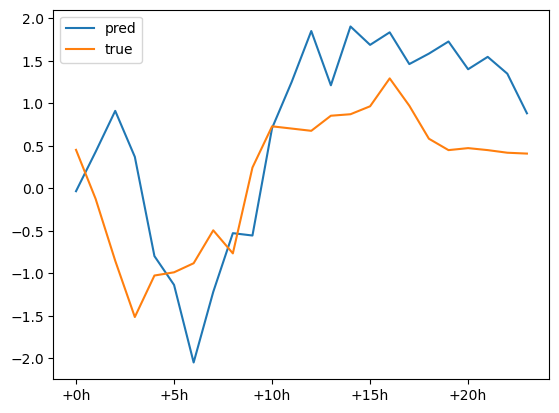

In [60]:
i = 20000
Y_preds_df.iloc[i].plot(label = 'pred')
tog_forecast.iloc[i][3:].plot(label = 'true')
plt.legend()
plt.show()

In [12]:
# evaluate MAE of together_forecast and Y_preds for each horizon
mae_ngboost = []
mae_tog = []
for i in range(24):
    mae_ngboost.append(mean_absolute_error(Y_preds_df.iloc[:,i], y_train.iloc[:,i]))
    mae_tog.append(mean_absolute_error(tog_forecast.iloc[:,i+3], y_train.iloc[:,i]))

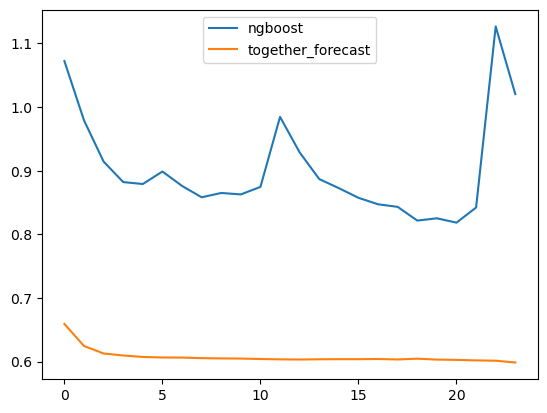

In [13]:
# plot MAE for each horizon
plt.plot(mae_ngboost, label='ngboost')
plt.plot(mae_tog, label='together_forecast')
plt.legend()
plt.show()